In [41]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pmlb
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data
import numpy.linalg as npl 
import numpy.random as npr
from scipy.optimize import minimize
# from process_results import process_results, aggregate_results, best_ridge
from scipy.stats import ortho_group
from sklearn.linear_model import LinearRegression, RidgeCV
import scipy.linalg as scl
import pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2

save_dir = 'results'
os.makedirs(save_dir, exist_ok=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import matplotlib as mpl
label_size = 20
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['figure.titlesize'] = 10
# mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 20
# pylab.rcParams['xtick.major.pad']=5
# pylab.rcParams['ytick.major.pad']=5

In [43]:
cs=sns.color_palette()

## MDL COMP FOR different eigenvalues decay of Matrices

In [47]:
np.sum(np.log(1+f**2 *eigenvals[:min(n, d)] * (w**2/noise_std**2)[:min(n, d)])) / n

1.8711756154949768

In [48]:
noise_std = 1.

In [49]:
np.sum(np.log(1+f**2 *eigenvals[:min(n, d)] * (w**2/noise_std**2)[:min(n, d)])) / n

0.14172606273661373

In [44]:
save_data = True

npr.seed(121123)


noise_std = 0.1
d0s = np.array([100, 400], dtype=int)
ds = np.array([20, 100, 200, 400, 1000, 2000])
ns = np.array([200])
epows = [0., 0.5]

num_norms = 2
num_trials = 3
rmt_mdl_comp = np.zeros((num_trials, num_norms, len(ds), len(ns), len(d0s), len(epows)))
rmt_mdl_comp_2 = np.zeros((num_trials, num_norms, len(ds), len(ns), len(d0s), len(epows)))
rmt_mdl_comp_3 = np.zeros((num_trials, num_norms, len(ds), len(ns), len(d0s), len(epows)))


new_rmt_mdl_comp = np.zeros((num_trials,num_norms, len(ds), len(ns), len(d0s), len(epows)))
new_rmt_mdl_comp_2 = np.zeros((num_trials,num_norms, len(ds), len(ns), len(d0s), len(epows)))
new_rmt_mdl_comp_3 = np.zeros((num_trials,num_norms, len(ds), len(ns), len(d0s), len(epows)))

dmax = max(ds)

beta_stars = np.zeros((len(d0s), dmax))
# initialize beta_Star fixed
for l, d0 in enumerate(d0s):
    beta_fixed = npr.randn(d0)
    beta_fixed /= npl.norm(beta_fixed)
    beta_stars[l, :d0] = beta_fixed


for m in tqdm(range(num_trials)):
    
    # change X_train
    for p, epow in enumerate(epows):
        
        eigs = np.diag(np.arange(1, dmax+1)**(-epow))
        X_train = npr.randn(max(ns), dmax) @ eigs

        y_train_stars = np.zeros((len(d0s), ns[0]))

        for ltemp, d0 in enumerate(d0s):
            y_train_stars[ltemp, :] = X_train[:, :d0] @ beta_stars[ltemp, :d0]

        for j, d in tqdm(enumerate(ds)):
            for k, n in enumerate(ns):
                X_train_d = X_train[:n, :d]
                eigenvals, eigenvecs = scl.eigh(X_train_d.T @ X_train_d)
                eigenvals = eigenvals[::-1]
                V, s, Uh = scl.svd(X_train_d, full_matrices=False)

                for l, d0 in enumerate(d0s):

                    w = eigenvecs.T @ beta_stars[l, :d]
                    w = w[::-1] # arrange in order

                    v = V.T @ y_train_stars[l, :]


                    for i in range(num_norms):
                        print(m, d0, i, d, n)
                        f = (i+1)**2

                        rmt_mdl_comp[m, i, j, k, l, p] = np.sum(np.log(1+f**2 *eigenvals[:min(n, d)] * (w**2/noise_std**2)[:min(n, d)])) / n
                        rmt_mdl_comp_2[m, i, j, k, l, p]  = rmt_mdl_comp[m, i, j, k, l, p] + np.sum(np.log((noise_std**2 / (f**2 * w**2))[:min(n, d)])) / n
                        rmt_mdl_comp_3[m, i, j, k, l, p] = rmt_mdl_comp_2[m, i, j, k, l, p] - np.log(0.005) * min(n, d)/n


                        new_rmt_mdl_comp[m, i, j, k, l, p] = np.sum(np.log(1+f**2 * v**2/noise_std**2)) / n
                        new_rmt_mdl_comp_2[m, i, j, k, l, p] = new_rmt_mdl_comp[m, i, j, k, l, p] + np.sum(np.log( noise_std**2 / (f**2 * v**2))) / n
                        new_rmt_mdl_comp_3[m, i, j, k, l, p] = new_rmt_mdl_comp_2[m, i, j, k, l, p] - np.log(0.005) *min(n, d)/n 

  0%|          | 0/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
3it [00:00, 22.87it/s]

0 100 0 20 200
0 100 1 20 200
0 400 0 20 200
0 400 1 20 200
0 100 0 100 200
0 100 1 100 200
0 400 0 100 200
0 400 1 100 200
0 100 0 200 200
0 100 1 200 200
0 400 0 200 200
0 400 1 200 200



4it [00:00, 10.72it/s]

0 100 0 400 200
0 100 1 400 200
0 400 0 400 200
0 400 1 400 200



5it [00:01,  2.19it/s]

0 100 0 1000 200
0 100 1 1000 200
0 400 0 1000 200
0 400 1 1000 200



6it [00:09,  2.53s/it]

0 100 0 2000 200
0 100 1 2000 200
0 400 0 2000 200
0 400 1 2000 200



0it [00:00, ?it/s]
3it [00:00, 22.50it/s]

0 100 0 20 200
0 100 1 20 200
0 400 0 20 200
0 400 1 20 200
0 100 0 100 200
0 100 1 100 200
0 400 0 100 200
0 400 1 100 200
0 100 0 200 200
0 100 1 200 200
0 400 0 200 200
0 400 1 200 200



4it [00:00, 10.42it/s]

0 100 0 400 200
0 100 1 400 200
0 400 0 400 200
0 400 1 400 200



5it [00:01,  2.11it/s]

0 100 0 1000 200
0 100 1 1000 200
0 400 0 1000 200
0 400 1 1000 200



 33%|███▎      | 1/3 [00:18<00:37, 18.98s/it]

0 100 0 2000 200
0 100 1 2000 200
0 400 0 2000 200
0 400 1 2000 200



0it [00:00, ?it/s]
3it [00:00, 21.10it/s]

1 100 0 20 200
1 100 1 20 200
1 400 0 20 200
1 400 1 20 200
1 100 0 100 200
1 100 1 100 200
1 400 0 100 200
1 400 1 100 200
1 100 0 200 200
1 100 1 200 200
1 400 0 200 200
1 400 1 200 200



4it [00:00,  9.76it/s]

1 100 0 400 200
1 100 1 400 200
1 400 0 400 200
1 400 1 400 200



5it [00:01,  1.97it/s]

1 100 0 1000 200
1 100 1 1000 200
1 400 0 1000 200
1 400 1 1000 200



6it [00:09,  2.58s/it]

1 100 0 2000 200
1 100 1 2000 200
1 400 0 2000 200
1 400 1 2000 200



0it [00:00, ?it/s]
3it [00:00, 29.38it/s]

1 100 0 20 200
1 100 1 20 200
1 400 0 20 200
1 400 1 20 200
1 100 0 100 200
1 100 1 100 200
1 400 0 100 200
1 400 1 100 200
1 100 0 200 200
1 100 1 200 200
1 400 0 200 200
1 400 1 200 200



4it [00:00, 14.51it/s]

1 100 0 400 200
1 100 1 400 200
1 400 0 400 200
1 400 1 400 200



5it [00:01,  3.16it/s]

1 100 0 1000 200
1 100 1 1000 200
1 400 0 1000 200
1 400 1 1000 200



 67%|██████▋   | 2/3 [00:35<00:18, 18.35s/it]

1 100 0 2000 200
1 100 1 2000 200
1 400 0 2000 200
1 400 1 2000 200



0it [00:00, ?it/s]
3it [00:00, 27.36it/s]

2 100 0 20 200
2 100 1 20 200
2 400 0 20 200
2 400 1 20 200
2 100 0 100 200
2 100 1 100 200
2 400 0 100 200
2 400 1 100 200
2 100 0 200 200
2 100 1 200 200
2 400 0 200 200
2 400 1 200 200



4it [00:00, 14.21it/s]

2 100 0 400 200
2 100 1 400 200
2 400 0 400 200
2 400 1 400 200



5it [00:01,  3.06it/s]

2 100 0 1000 200
2 100 1 1000 200
2 400 0 1000 200
2 400 1 1000 200



6it [00:31,  9.24s/it]

2 100 0 2000 200
2 100 1 2000 200
2 400 0 2000 200
2 400 1 2000 200



0it [00:00, ?it/s]
3it [00:00, 28.66it/s]

2 100 0 20 200
2 100 1 20 200
2 400 0 20 200
2 400 1 20 200
2 100 0 100 200
2 100 1 100 200
2 400 0 100 200
2 400 1 100 200
2 100 0 200 200
2 100 1 200 200
2 400 0 200 200
2 400 1 200 200



4it [00:00, 13.79it/s]

2 100 0 400 200
2 100 1 400 200
2 400 0 400 200
2 400 1 400 200



5it [00:01,  2.94it/s]

2 100 0 1000 200
2 100 1 1000 200
2 400 0 1000 200
2 400 1 1000 200



100%|██████████| 3/3 [01:15<00:00, 24.67s/it]

2 100 0 2000 200
2 100 1 2000 200
2 400 0 2000 200
2 400 1 2000 200


In [45]:
if save_data:
    results = {'ns': ns, 'd0s': d0s,  'ds' : ds,
               'epows': epows,
               'num_trials': num_trials, 
               'num_norms': num_norms,
               'noise_var': noise_std**2,
                'rmt_mdl_comp': rmt_mdl_comp,
               'rmt_mdl_comp_2':rmt_mdl_comp_2,
               'rmt_mdl_comp_3' : rmt_mdl_comp_3,
               'new_rmt_mdl_comp': new_rmt_mdl_comp,
               'new_rmt_mdl_comp_2': new_rmt_mdl_comp_2,
               'new_rmt_mdl_comp_3': new_rmt_mdl_comp_3
              }
    file = open('decay_mdl_n_%d_noise_%d.txt'%(ns[0], noise_std), 'wb')
    pickle.dump(results, file)
    file.close()
    
# results = pickle.load(open('decay_mdl_n_200.txt', 'rb'))

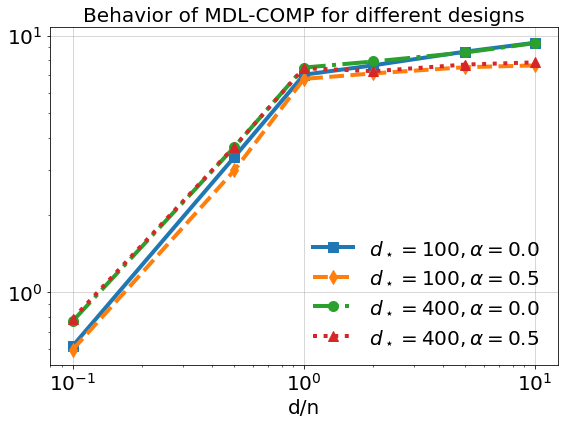

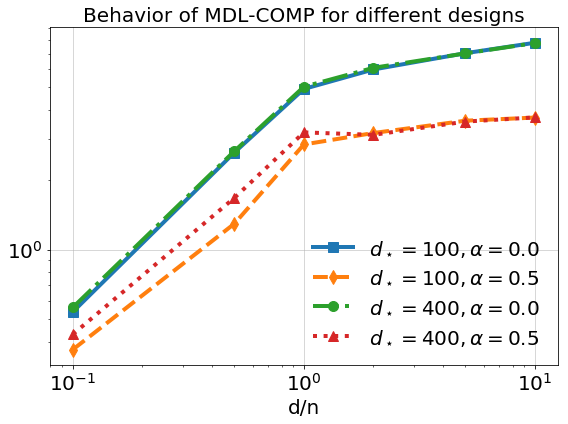

In [62]:
save_fig = True
for ff, (file, noise_std) in enumerate(zip(['decay_mdl_n_200_noise_1.txt', 'decay_mdl_n_200_noise_0.txt'], [1, .1])):
    results = pickle.load(open(file, 'rb'))
    
    num_norms = results["num_norms"]
    d0s = results["d0s"]
    ns = results["ns"]
    ds = results["ds"]
    rmt_mdl_comp = results["rmt_mdl_comp"]
    rmt_mdl_comp_2 = results["rmt_mdl_comp_2"]
    rmt_mdl_comp_3 = results["rmt_mdl_comp_3"]


    lss = ['-', '--', '-.', ':']
    mss = ['s', 'd', 'o', '^']
    n = ns[0]
    gammas = ds/n

    for i in range(1):
#         plt.figure(figsize=[8, 6])

#         plt.loglog(gammas, rmt_mdl_comp.mean(0)[i, :, 0, 0, 0],   color=cs[0], linestyle=lss[0], linewidth=4.,  marker=mss[0],  markersize=10, label=r'$d_\star=%d, \alpha=%.1f$'%(d0s[0], epows[0]))
#         plt.loglog(gammas, rmt_mdl_comp.mean(0)[i, :, 0, 0, 1],   color=cs[1], linestyle=lss[1], linewidth=4.,  marker=mss[1],  markersize=10, label=r'$d_\star=%d, \alpha=%.1f$'%(d0s[0], epows[1]))
#         plt.loglog(gammas, rmt_mdl_comp.mean(0)[i, :, 0, 1, 0],   color=cs[2], linestyle=lss[2], linewidth=4.,  marker=mss[2],  markersize=10, label=r'$d_\star=%d, \alpha=%.1f$'%(d0s[1], epows[0]))
#         plt.loglog(gammas, rmt_mdl_comp.mean(0)[i, :, 0, 1, 1],   color=cs[3], linestyle=lss[3], linewidth=4.,  marker=mss[3],  markersize=10, label=r'$d_\star=%d, \alpha=%.1f$'%(d0s[1], epows[1]))

#         plt.grid(True, alpha=0.5, linewidth=1.)
#         plt.legend(frameon=False, fontsize=20) 
#         if ff==1:
#             plt.ylim([5e-2, 5e0])
#         plt.title(r'Behavior of MDL-COMP ($n=200$)', fontsize=20)
#         plt.xlabel('d/n')
#         plt.tight_layout()
#         if save_fig:
#             plt.savefig('fig3/decay_mdl_comp_norm_%d_n_%d_noise_std_%d.pdf'%((i+1)**2, n, noise_std))
#         plt.show()

        plt.figure(figsize=[8, 6])

        plt.loglog(gammas, rmt_mdl_comp_2.mean(0)[i, :, 0, 0, 0],   color=cs[0], linestyle=lss[0], linewidth=4.,  marker=mss[0],  markersize=10, label=r'$d_\star=%d, \alpha=%.1f$'%(d0s[0], epows[0]))
        plt.loglog(gammas, rmt_mdl_comp_2.mean(0)[i, :, 0, 0, 1],   color=cs[1], linestyle=lss[1], linewidth=4.,  marker=mss[1],  markersize=10, label=r'$d_\star=%d, \alpha=%.1f$'%(d0s[0], epows[1]))
        plt.loglog(gammas, rmt_mdl_comp_2.mean(0)[i, :, 0, 1, 0],   color=cs[2], linestyle=lss[2], linewidth=4.,  marker=mss[2],  markersize=10, label=r'$d_\star=%d, \alpha=%.1f$'%(d0s[1], epows[0]))
        plt.loglog(gammas, rmt_mdl_comp_2.mean(0)[i, :, 0, 1, 1],   color=cs[3], linestyle=lss[3], linewidth=4.,  marker=mss[3],  markersize=10, label=r'$d_\star=%d, \alpha=%.1f$'%(d0s[1], epows[1]))

        plt.grid(True, alpha=0.5, linewidth=1.)
        plt.legend(frameon=False, fontsize=20) 
        plt.xlabel('d/n')
    #     plt.ylim([5e-2, 5e0])
        plt.title(r'Behavior of MDL-COMP for different designs', fontsize=20)
        plt.tight_layout()
        if save_fig:
            plt.savefig('fig3/decay_new_mdl_comp_norm_%d_n_%d_noise_std_%d.pdf'%((i+1)**2, n, noise_std))
        plt.show()

In [57]:
def loc_calc_thetahat(l):
    inv = scl.pinv(X_train_d.T @ X_train_d + l * np.eye(d))
#     inv = eigenvecs @ npl.pinv(np.eye(d) + np.diag(eigenvals)) @ eigenvecs.T
    return inv @ X_train_d.T @ y_train_n

def loc_mdl1_loss(l):
    thetahat = loc_calc_thetahat(l)
    mse_norm = npl.norm(y_train_n - X_train_d @ thetahat)**2 / (2 * var)
    theta_norm = npl.norm(thetahat)**2 / (2 * var)
    eigensum = 0.5 * np.sum(np.log((eigenvals + l) / l))
    return (mse_norm + theta_norm + eigensum) / n


def loc_mdl1_loss_ret_all(l):
    thetahat = loc_calc_thetahat(l)
    mse_norm = npl.norm(y_train_n - X_train_d @ thetahat)**2 / (2 * var)
    theta_norm = npl.norm(thetahat)**2 / (2 * var)
    eigensum = 0.5 * np.sum(np.log((eigenvals + l) / l))
    return mse_norm/n , theta_norm/n,  eigensum / n

def g(a, b):
    val = np.sqrt(a*(1+np.sqrt(b))**2+1)
    val -= np.sqrt(a*(1-np.sqrt(b))**2+1)
    val = val**2
    return(val/4)

def thm3(gammas, snr):
    delta = g(snr, gammas)
    bnd = gammas * np.log(1+snr-delta)
    bnd += np.log(1+gammas * snr - delta)
    bnd -= delta/snr
    return(bnd)

In [58]:
results = pickle.load(open('prac_mdl_n_200_noise_0.txt', 'rb'))

# results = pickle.load(open('prac_mdl_n_%d_noise_%d.txt'%(ns[0], noise_std), 'rb'))
save_fig = False

ds = results["ds"]
ns = results["ns"]
d0s = results["d0s"]
rmt_mdl_comp = results["rmt_mdl_comp"]
eigsum  = results["eigsum"]
n = ns[0]
gammas = ds/n

lss = ['-', '--', '-.', ':']
mss = ['s', 'd', 'o', '^']

for i in range(1):
    for l, d0 in enumerate(d0s):
        plt.figure(figsize=[8, 6])

        plt.loglog(gammas, rmt_mdl_comp.mean(0)[i, :, 0, l, 0],   color=cs[0], linestyle=lss[0], linewidth=4.,  marker=mss[0],  markersize=10, label='MDL-COMP (Thm1)')
        plt.loglog(gammas, thm3(gammas, np.minimum(d0,ds)/ds),  color=cs[1], linestyle=lss[1], linewidth=4.,  marker=mss[1], markersize=10, label='MDL-COMP (Thm2)')
        plt.loglog(gammas, eigsum.mean(0)[i, :, 0, l, 0], color=cs[2], linestyle=lss[2], linewidth=4.,  marker=mss[2], markersize=10, label= 'Prac-MDL-COMP (Eigensum)')
        plt.grid(True, alpha=0.5, linewidth=1.)
#         plt.ylim([1e-3, 8e-1])
        plt.legend(frameon=False, fontsize=20) 
        plt.title(r'Different MDL-COMP ($n=%d, d_\star=%d$)'%(ns[0], d0), fontsize=20)
        plt.xlabel('d/n')
        plt.tight_layout()
        if save_fig:
            plt.savefig('fig3/prac_mdl_comp_norm_%d_n_%d_noise_%d_d0_%d.pdf'%((i+1)**2, n, noise_std, d0))
        plt.show()

KeyError: 'eigsum'